In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
# import the Apple data
y = pd.read_csv('AAPL_quarterly_financials.csv')
# convert the name to index
y.index = y.name
y = pd.DataFrame(y.loc['BasicEPS', :])
y = y.iloc[2:, :].iloc[::-1]
y = y.fillna(0.)
y

,BasicEPS
09/30/1985,0.0
12/31/1985,0.004
03/31/1986,0.002
06/30/1986,0.002
09/30/1986,0.0
...,...
09/30/2022,1.29
12/31/2022,1.89
03/31/2023,1.53
06/30/2023,1.27


In [3]:
# y = y.sort_index().fillna(0.)
# create the y dataframe so that is has the same size as out X dataframe
y = y.iloc[74:, :].copy()
y

,BasicEPS
03/31/2004,0.002
06/30/2004,0.003
09/30/2004,0.0
12/31/2004,0.013
03/31/2005,0.013
...,...
09/30/2022,1.29
12/31/2022,1.89
03/31/2023,1.53
06/30/2023,1.27


# 1.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [4]:
from pytrends.request import TrendReq

In [5]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ['iPhone', "Recession", 'Interest Rates', 'Inflation Rates', 'Tech Industry Trends', 'Apple Stock Performance']
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    #time.sleep(5)
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [6]:
X = df.resample('Q').mean()
X = X.iloc[:79, :]
X

,iPhone,Recession,Interest Rates,Inflation Rates,Tech Industry Trends,Apple Stock Performance
date,,,,,,
2004-03-31,0.000000,7.333333,60.333333,65.666667,17.666667,0.000000
2004-06-30,0.000000,7.666667,67.000000,85.000000,0.000000,0.000000
2004-09-30,0.000000,6.000000,53.000000,53.666667,33.333333,0.000000
2004-12-31,0.000000,7.333333,46.666667,61.333333,12.333333,0.000000
2005-03-31,0.000000,6.000000,49.000000,61.666667,6.333333,0.000000
...,...,...,...,...,...,...
2022-09-30,55.666667,56.333333,75.333333,55.666667,6.000000,21.333333
2022-12-31,51.333333,48.333333,80.000000,54.333333,9.666667,21.666667
2023-03-31,49.333333,36.666667,86.000000,49.666667,13.666667,20.000000


# 2.) Normalize all the X data

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3.) Import data. Train, Test, Holdout (80%,15%,5%)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# split the data into train(80%) and (test + holdout)(20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# split the (test+holdout)(20%) into test(15%) and holdout(5%)
X_test, X_holdout, y_test, y_holdout = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [11]:
from sklearn.linear_model import Lasso

In [12]:
lasso = Lasso(alpha=0.05)
lasso.fit(X_scaled, y)
coefficients = lasso.coef_

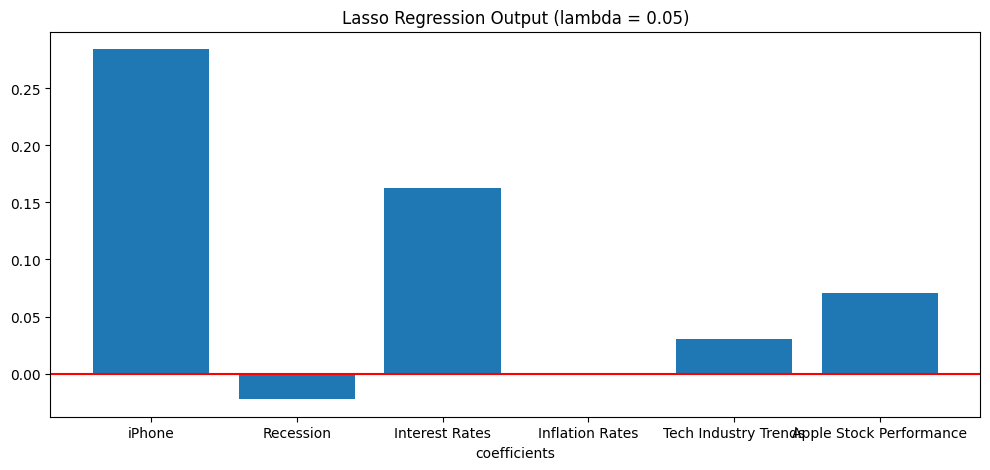

In [13]:
plt.figure(figsize=(12, 5))
plt.bar(X.columns, coefficients)
plt.axhline(0, color='red')
plt.xlabel('coefficients')
plt.title('Lasso Regression Output (lambda = 0.05)')
plt.show()

# 5.) Do these coefficient magnitudes make sense?

Yes, these coefficients magnitudes make sense. When comparing to the coefficients where labmda=0 (where coefficients eqaul to those estimated by OLS regression), the coefficient of the inflation rate is the smallest. Thus, as we increase lambda to increase the penaly, the coefficient of inflation rate shrinks to zero.

/var/folders/jk/76wv01tj2_s1d7lbkvfn6_680000gn/T/ipykernel_39475/743186179.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_scaled, y)
/Users/clairewei/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/clairewei/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.583e+00, tolerance: 2.085e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_

<function matplotlib.pyplot.show(close=None, block=None)>

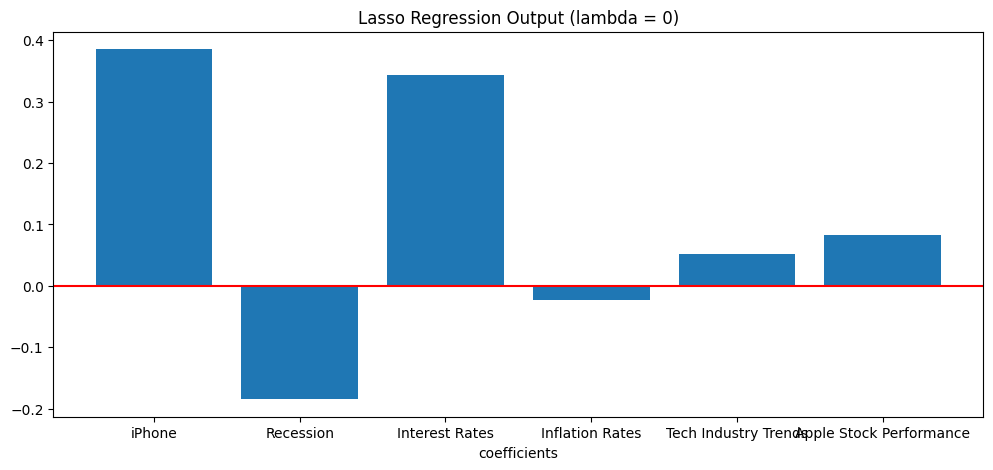

In [14]:
lasso = Lasso(alpha=0.)
lasso.fit(X_scaled, y)
coefficients = lasso.coef_

plt.figure(figsize=(12, 5))
plt.bar(X.columns, coefficients)
plt.axhline(0, color='red')
plt.xlabel('coefficients')
plt.title('Lasso Regression Output (lambda = 0)')
plt.show

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

# 7.) Run a cross validation. What is your ideal lambda?